# Статистический анализ данных сервиса GoFast

**Описание проекта:**

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1. без подписки:
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra:
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

**Описание данных:**


В основных данных есть информация о пользователях, их поездках и подписках.
1. Данные о пользователях:
- user_id — уникальный идентификатор пользователя;
- name —  имя пользователя;
- age — возраст;
- city — город;
- subscription_type — тип подписки (free, ultra).
2. Данные о поездках:
- user_id — уникальный идентификатор пользователя;
- distance — расстояние, которое пользователь проехал в текущей сессии (в метрах);
- duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- date — дата совершения поездки.
3. Данные о подписках:
- subscription_type — тип подписки;
- minute_price — стоимость одной минуты поездки по данной подписке;
- start_ride_price — стоимость начала поездки;
- subscription_fee — стоимость ежемесячного платежа.

**Основная цель проекта** — проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

## Шаг 0. Импорт и настройка библиотек

In [1]:
import pandas as pd
import numpy as np
import os

from scipy import stats as st

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)

## Шаг 1. Загрузка и обзор данных

**Считаем csv-файлы:**

In [2]:
pth1 = 'C:/pr/pr_3/users_go.csv' 
pth2 = '/datasets/users_go.csv'
pth3 = 'C:/pr/pr_3/rides_go.csv' 
pth4 = '/datasets/rides_go.csv'
pth5 = 'C:/pr/pr_3/subscriptions_go.csv' 
pth6 = '/datasets/subscriptions_go.csv'

if os.path.exists(pth1):
    df_users = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_users = pd.read_csv(pth2)
else:
    print('Something is wrong')

if os.path.exists(pth3):
    df_rides = pd.read_csv(pth3, parse_dates=['date'])
elif os.path.exists(pth4):
    df_rides = pd.read_csv(pth4, parse_dates=['date'])
else:
    print('Something is wrong')

if os.path.exists(pth5):
    df_subs = pd.read_csv(pth5)
elif os.path.exists(pth6):
    df_subs = pd.read_csv(pth6)
else:
    print('Something is wrong')

**Изучим общую информацию о датафреймах, однако, прежде, чем мы приступим к их разбору, напишем вспомогательную функцию для того, чтобы проводить анализ было быстрее и удобнее:**

In [3]:
def describe_data (data):
    print('Первые 5 строк таблицы:\n\n', data.head(), '\n')
    print('Последние 5 строк таблицы:\n\n', data.tail(), '\n\n', 'Общая информация о датафрейме:\n')
    print(data.info(), '\n')
    print('Описательные статистики датафрейма:\n\n', data.describe().round(2), '\n')
    print('Количество дубликатов в данных:\n\n', data.duplicated().sum(), '\n')

In [4]:
describe_data(df_users) # Рассматриваем данные о пользователях

Первые 5 строк таблицы:

    user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra 

Последние 5 строк таблицы:

       user_id     name  age            city subscription_type
1560      829    Федор   29       Пятигорск              free
1561      809     Юрий   26            Сочи              free
1562      307   Ясмина   19       Краснодар             ultra
1563       47     Юрий   28          Тюмень             ultra
1564     1045  Артемий   28  Ростов-на-Дону              free 

 Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------

In [5]:
describe_data(df_rides) # Рассматриваем данные о поездках

Первые 5 строк таблицы:

    user_id     distance   duration       date
0        1  4409.919140  25.599769 2021-01-01
1        1  2617.592153  15.816871 2021-01-18
2        1   754.159807   6.232113 2021-04-20
3        1  2694.783254  18.511000 2021-08-11
4        1  4028.687306  26.265803 2021-08-28 

Последние 5 строк таблицы:

        user_id     distance   duration       date
18063     1534  3781.098080  19.822962 2021-11-04
18064     1534  2840.423057  21.409799 2021-11-16
18065     1534  3826.185507  18.435051 2021-11-18
18066     1534  2902.308661  16.674362 2021-11-27
18067     1534  2371.711192  15.893917 2021-12-29 

 Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64  

In [6]:
describe_data(df_subs) # Рассматриваем данные о подписках

Первые 5 строк таблицы:

   subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199 

Последние 5 строк таблицы:

   subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199 

 Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None 

Описательные статистики датафрейма:

       

**Промежуточный вывод:**

Проблем при выгрузке данных не возникло, пропусков нет. Однако, сразу можем заметить, что в данных о пользователях имеются дубликаты. Избавимся от них на следующем этапе.

## Шаг 2. Предобработка данных

**В первую очередь избавляемся от найденных на предыдущем этапе явных дубликатов:**

In [7]:
df_users = df_users.drop_duplicates() 
df_users.duplicated().sum() # Проверяем, что количество пропусков стало равно нулю

0

**Далее разбираемся с дубликатами неявными. Они потенциально могут возникнуть в столбцах со строковыми данными — например, с именами и названиями городов в "пользовательском" датафрейме. Для начала изучим имена:**

In [8]:
len(df_users['name'].unique()) # Находим количество уникальных названий

194

In [9]:
df_users['name'].unique().tolist() # Выводим список для ознакомления

['Кира',
 'Станислав',
 'Алексей',
 'Константин',
 'Адель',
 'Регина',
 'Игорь',
 'Юрий',
 'Ян',
 'Валерий',
 'Агата',
 'Марк',
 'Ева',
 'Антонина',
 'Валерия',
 'Амалия',
 'Даниил',
 'Аделина',
 'Святогор',
 'Борис',
 'Вероника',
 'Ростислав',
 'Назар',
 'Эдуард',
 'Василий',
 'Денис',
 'Тамара',
 'Николай',
 'Эвелина',
 'Федор',
 'Руслан',
 'Иван',
 'Любовь',
 'Ярослава',
 'Майя',
 'Ильдар',
 'Данила',
 'Нина',
 'Стефания',
 'Ясмина',
 'Дмитрий',
 'Александр',
 'Одиссей',
 'Арсений',
 'Алла',
 'Таисия',
 'Максим',
 'Юлиана',
 'Павел',
 'Карина',
 'Алиса',
 'Лидия',
 'Рамиль',
 'Родион',
 'Ника',
 'Оксана',
 'Анастасия',
 'Маргарита',
 'Вера',
 'Тимур',
 'Никита',
 'Лев',
 'Влад',
 'Артур',
 'Анна',
 'Ольга',
 'Вячеслав',
 'Ксения',
 'Виталина',
 'Владислав',
 'Тамерлан',
 'Амина',
 'Вадим',
 'Олеся',
 'Зарина',
 'Егор',
 'Гордей',
 'Лилия',
 'Святослав',
 'Роберт',
 'Амир',
 'Влада',
 'Богдан',
 'Полина',
 'Марат',
 'Елисей',
 'Макар',
 'Алина',
 'Глеб',
 'Андрей',
 'Альбина',
 'Людм

**Сразу заметим, что можно быстро отсечь возможные проблемы с регистрами — все имена написаны с заглавной буквы. Остаётся проверить потенциальные дубликаты с "е-ё". Для этого заменим все "ё" на "е" и посмотрим, изменится ли количество уникальных имён:**

In [10]:
df_users['name'] = (df_users['name'].str.replace('ё', 'е'))
len(df_users['name'].unique())

194

**Количество уникальных значений в данном столбце осталось таким же, что говорит об отсутствии неявных дубликатов в нём.**

**Теперь рассмотрим уникальные значения в столбце *city*:**

In [11]:
len(df_users['city'].unique()) # Находим количество уникальных названий

8

In [12]:
df_users['city'].unique().tolist() # Выводим список для ознакомления

['Тюмень',
 'Омск',
 'Москва',
 'Ростов-на-Дону',
 'Краснодар',
 'Пятигорск',
 'Екатеринбург',
 'Сочи']

**Здесь, очевидно, неявных дубликатов нет.**

**Остаётся только подготовить данные для проведения исследовательского анализа. Для этого мы добавим столбец *month* с номером месяца в датафрейм с данными о поездках (он пригодится нам впоследствии):**

In [13]:
df_rides['month'] = pd.DatetimeIndex(df_rides['date']).month

**Промежуточный вывод:**

На этом шаге были обработаны явные дубликаты, обнаруженные на этапе обзора данных, а также добавлен вспомогательный столбец *month*, содержащий номер месяца поездки. В остальном, исходные данные практически не нуждаются в предобработке для проведения дальнейшего анализа.

## Шаг 3. Исследовательский анализ данных

**Детальнее изучим несколько параметров на предмет возникновения аномалий и выбросов в данных**

### 3.1. Частота встречаемости городов

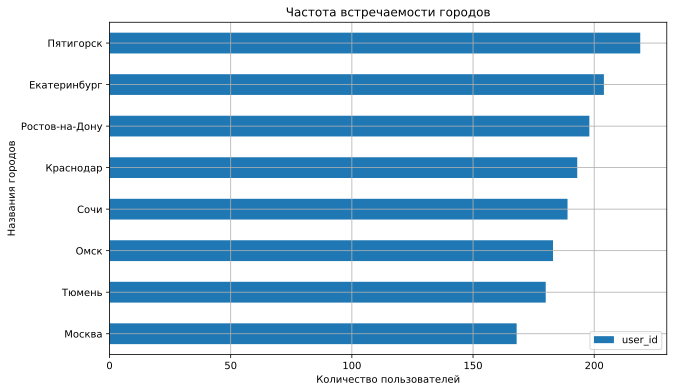

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [14]:
df_users_city = df_users.pivot_table(index='city', values='user_id', aggfunc='count')
df_users_city = df_users_city.sort_values(by='user_id', ascending=True)
df_users_city.plot(kind='barh', grid=True )
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Названия городов')
plt.show()
display(df_users_city.sort_values(by='user_id', ascending=False))

**Наибольшее количество пользователей — в Пятигорске. Наименьшее — в Москве**

### 3.2. Соотношение пользователей с подпиской и без подписки

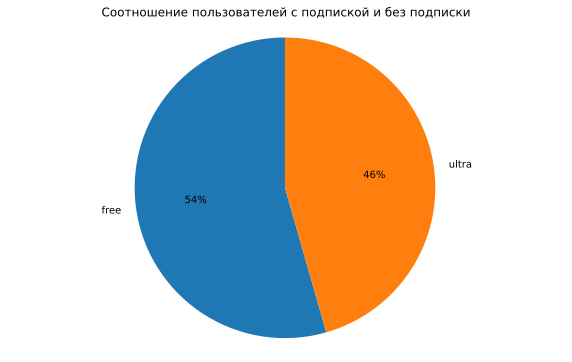

,subscription_type,user_id
0,free,835
1,ultra,699


In [15]:
df_users_subs = df_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count').reset_index()
df_users_subs['user_id'].plot.pie(labels=df_users_subs['subscription_type'], ylabel = '', autopct = '%1.0f%%', startangle=90)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.axis('equal')
plt.show()
display(df_users_subs)

**Пользователей с подпиской меньше, чем пользователей без неё. Выясним, насколько:**

In [16]:
subs = df_users_subs['user_id'].values[1]
unsubs = df_users_subs['user_id'].values[0]
print('Процент пользователей без подписки:', ((unsubs / (subs + unsubs))*100).round(2), '%')
print('Процент пользователей с подпиской:', ((subs / (subs + unsubs))*100).round(2), '%')

Процент пользователей без подписки: 54.43 %
Процент пользователей с подпиской: 45.57 %


### 3.3. Возраст пользователей

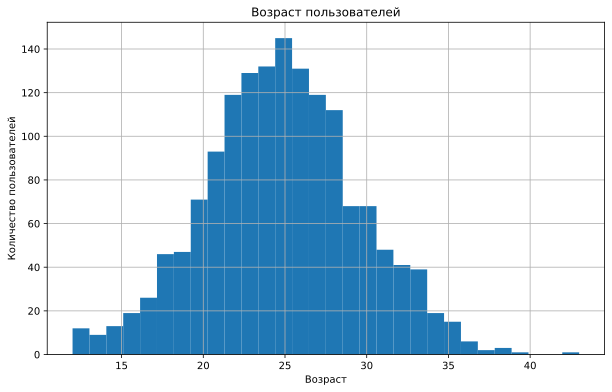

count    1534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

In [17]:
df_users['age'].plot(kind='hist', grid=True, bins=30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()
df_users['age'].describe().round(2)

**Возраст пользователей колеблется от 12-ти до 43-х лет. Распределение очень близко к нормальному. Наибольшее количество составляют люди возраста 25-ти лет, что совпадает с медианным значением.**

### 3.4. Расстояние, преодолеваемое пользователями за одну поездку

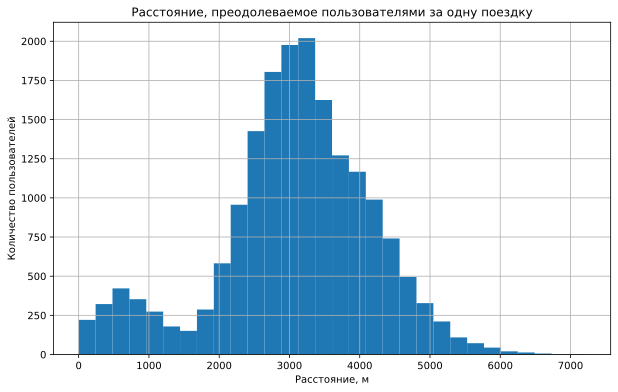

count    18068.00
mean      3070.66
std       1116.83
min          0.86
25%       2543.23
50%       3133.61
75%       3776.22
max       7211.01
Name: distance, dtype: float64

In [18]:
df_rides['distance'].plot(kind='hist', grid=True, bins = 30)
plt.title('Расстояние, преодолеваемое пользователями за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.show()
df_rides['distance'].describe().round(2)

**Среднее и медианное расстояния различаются незначительно и составляют чуть более трёх километров. По гистограмме можно заметить всплеск значений в районе полукилометра. Вероятно, данные поездки пользователи совершали с целью добраться до ближайших станций метро или остановок общественного транспорта.**

### 3.5. Продолжительность поездок

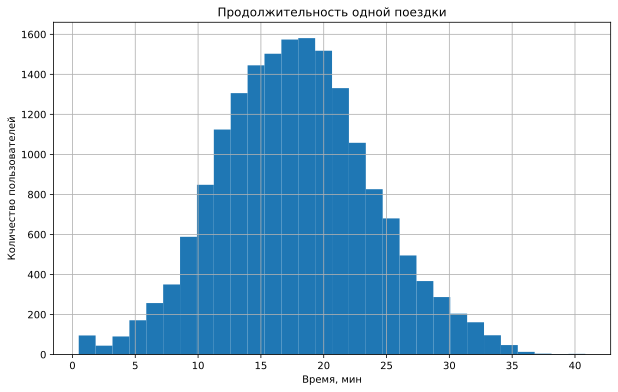

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [19]:
df_rides['duration'].plot(kind='hist', grid=True, bins = 30)
plt.title('Продолжительность одной поездки')
plt.xlabel('Время, мин')
plt.ylabel('Количество пользователей')
plt.show()
df_rides['duration'].describe()

**Значения распределены нормально; медиана и среднее довольно близки и составляют почти 18 минут.**

### 3.6. Промежуточные выводы

- Наиболее часто услугами сервиса пользуются в Пятигорске — там совершено 219 поездок. Наименее часто — в Москве (168 поездок).
- Большинство пользователей не имеют подписки на сервис. Их 835 человек, что составляет 54,43% от общего числа. Процент пользователей с подпиской, соответственно, 45.57% — их 699 человек.
- Возраст пользователей — от 12-ти до 43-х лет. Большинство — люди возраста 25-ти лет.
- За одну поездку пользователи в среднем преодолевают около трёх километров. Однако, есть всплеск значений в районе полукилометра, вероятно, обусловленный необходимостью пользователей добраться до ближайшей остановки общественного транспорта или станции метро.
- Средняя продолжительность поездки составляет порядка 18 минут.

## Шаг 4. Объединение данных

**Объединим данные о пользователях, поездках и подписках в один датафрейм:**

In [20]:
df_merged = df_users.merge(df_rides, on='user_id').merge(df_subs, on='subscription_type')
df_merged.head() # Выведем первые 5 строк новой таблицы, чтобы увидеть результат

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


**Перегруппируем столбцы для лучшего восприятия информации:**

In [21]:
df_merged = df_merged[[
    'user_id',
    'name',
    'age',
    'city',
    'distance',
    'duration',
    'date',
    'month',
    'subscription_type',
    'subscription_fee',
    'start_ride_price',
    'minute_price'
]] # Группируем параметры 
df_merged

,user_id,name,age,city,distance,duration,date,month,subscription_type,subscription_fee,start_ride_price,minute_price
0,1,Кира,22,Тюмень,4409.919140,25.599769,2021-01-01,1,ultra,199,0,6
1,1,Кира,22,Тюмень,2617.592153,15.816871,2021-01-18,1,ultra,199,0,6
2,1,Кира,22,Тюмень,754.159807,6.232113,2021-04-20,4,ultra,199,0,6
3,1,Кира,22,Тюмень,2694.783254,18.511000,2021-08-11,8,ultra,199,0,6
4,1,Кира,22,Тюмень,4028.687306,26.265803,2021-08-28,8,ultra,199,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,3781.098080,19.822962,2021-11-04,11,free,0,50,8
18064,1534,Альберт,25,Краснодар,2840.423057,21.409799,2021-11-16,11,free,0,50,8
18065,1534,Альберт,25,Краснодар,3826.185507,18.435051,2021-11-18,11,free,0,50,8
18066,1534,Альберт,25,Краснодар,2902.308661,16.674362,2021-11-27,11,free,0,50,8


**Также создадим новые вспомогательные датафреймы из *df_merged*: один с данными о пользователях с подпиской, а другой — без неё.**

In [22]:
df_ultra = df_merged.loc[df_merged['subscription_type'] == 'ultra'] 
df_ultra

,user_id,name,age,city,distance,duration,date,month,subscription_type,subscription_fee,start_ride_price,minute_price
0,1,Кира,22,Тюмень,4409.919140,25.599769,2021-01-01,1,ultra,199,0,6
1,1,Кира,22,Тюмень,2617.592153,15.816871,2021-01-18,1,ultra,199,0,6
2,1,Кира,22,Тюмень,754.159807,6.232113,2021-04-20,4,ultra,199,0,6
3,1,Кира,22,Тюмень,2694.783254,18.511000,2021-08-11,8,ultra,199,0,6
4,1,Кира,22,Тюмень,4028.687306,26.265803,2021-08-28,8,ultra,199,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,3973.046497,24.671163,2021-08-29,8,ultra,199,0,6
6496,699,Оксана,22,Москва,3288.702563,15.892886,2021-09-12,9,ultra,199,0,6
6497,699,Оксана,22,Москва,3076.159348,14.389525,2021-09-26,9,ultra,199,0,6
6498,699,Оксана,22,Москва,4707.845501,15.839579,2021-10-17,10,ultra,199,0,6


In [23]:
df_ultra.describe() # Выводим описательные статистики данных о пользователях с подпиской

,user_id,age,distance,duration,date,month,subscription_fee,start_ride_price,minute_price
count,6500.000000,6500.000000,6500.000000,6500.000000,6500,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,2021-06-28 21:31:34.153846016,6.422308,199.0,0.0,6.0
min,1.000000,12.000000,244.210438,3.760353,2021-01-01 00:00:00,1.000000,199.0,0.0,6.0
25%,175.000000,22.000000,2785.444017,14.524654,2021-04-01 00:00:00,4.000000,199.0,0.0,6.0
50%,351.000000,25.000000,3148.637229,18.178153,2021-06-27 00:00:00,6.000000,199.0,0.0,6.0
75%,525.000000,28.000000,3560.574425,21.884129,2021-09-25 00:00:00,9.000000,199.0,0.0,6.0
max,699.000000,38.000000,5699.769662,40.823963,2021-12-30 00:00:00,12.000000,199.0,0.0,6.0
std,201.099339,4.757208,836.895330,5.572048,NaN,3.414616,0.0,0.0,0.0


In [24]:
df_free = df_merged.loc[df_merged['subscription_type'] == 'free']
df_free

,user_id,name,age,city,distance,duration,date,month,subscription_type,subscription_fee,start_ride_price,minute_price
6500,700,Айдар,22,Омск,2515.690719,14.944286,2021-01-02,1,free,0,50,8
6501,700,Айдар,22,Омск,846.932642,16.234663,2021-02-01,2,free,0,50,8
6502,700,Айдар,22,Омск,4004.434142,20.016628,2021-02-04,2,free,0,50,8
6503,700,Айдар,22,Омск,1205.911290,9.782872,2021-02-10,2,free,0,50,8
6504,700,Айдар,22,Омск,3047.379435,17.427673,2021-02-14,2,free,0,50,8
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,3781.098080,19.822962,2021-11-04,11,free,0,50,8
18064,1534,Альберт,25,Краснодар,2840.423057,21.409799,2021-11-16,11,free,0,50,8
18065,1534,Альберт,25,Краснодар,3826.185507,18.435051,2021-11-18,11,free,0,50,8
18066,1534,Альберт,25,Краснодар,2902.308661,16.674362,2021-11-27,11,free,0,50,8


In [25]:
df_free.describe() # Выводим описательные статистики данных о пользователях без подписки

,user_id,age,distance,duration,date,month,subscription_fee,start_ride_price,minute_price
count,11568.000000,11568.000000,11568.000000,11568.000000,11568,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,24.893326,3045.495282,17.390909,2021-07-01 21:47:03.236514560,6.522994,0.0,50.0,8.0
min,700.000000,12.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000,0.0,50.0,8.0
25%,915.000000,22.000000,2366.562689,12.958437,2021-04-02 00:00:00,4.000000,0.0,50.0,8.0
50%,1123.000000,25.000000,3114.648465,17.326890,2021-07-01 00:00:00,7.000000,0.0,50.0,8.0
75%,1328.000000,28.000000,3905.697894,21.594071,2021-09-30 00:00:00,9.000000,0.0,50.0,8.0
max,1534.000000,43.000000,7211.007745,34.948498,2021-12-30 00:00:00,12.000000,0.0,50.0,8.0
std,241.165628,4.481100,1246.173806,6.326803,NaN,3.449770,0.0,0.0,0.0


**Наконец, найдём различия в данных пользователей с подпиской и без неё. Для этого сначала визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий:**

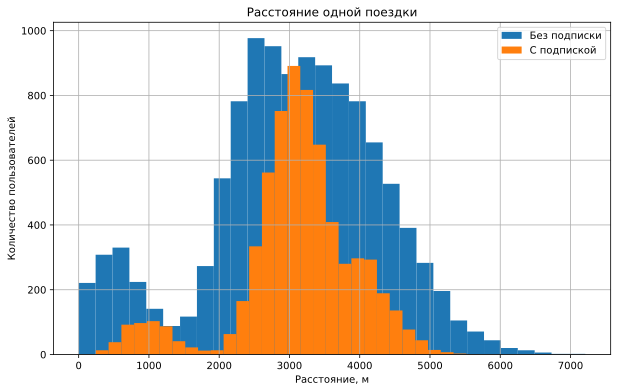

In [26]:
# Визуализируем данные о расстоянии одной поездки для пользователей обеих категорий:
ax = df_free['distance'].plot(kind='hist', bins=30, grid=True, label='Без подписки')
ax = df_ultra['distance'].plot(kind='hist', bins=30, grid=True, label='C подпиской')
plt.title('Расстояние одной поездки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.show()

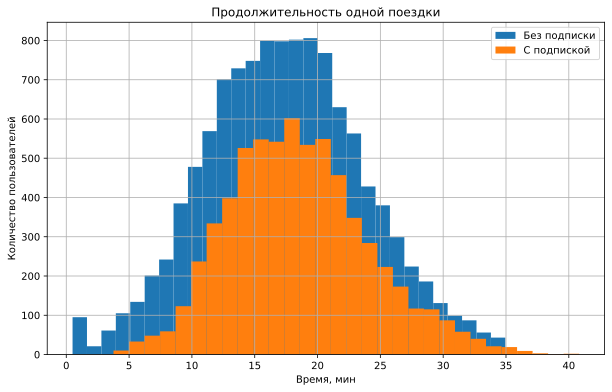

In [27]:
# Визуализируем данные о продолжительности одной поездки для пользователей обеих категорий:
ax = df_free['duration'].plot(kind='hist', bins=30, grid=True, label='Без подписки')
ax = df_ultra['duration'].plot(kind='hist', bins=30, grid=True, label='C подпиской')
plt.title('Продолжительность одной поездки')
plt.xlabel('Время, мин')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.show()

**Для того чтобы сделать более подробный вывод о разнице между двумя категориями пользователей изучим также разницу их описательных статистик:**

In [28]:
df_free.describe() - df_ultra.describe()

,user_id,age,distance,duration,date,month,subscription_fee,start_ride_price,minute_price
count,5068.000000,5068.000000,5068.000000,5068.000000,5068,5068.000000,5068.0,5068.0,5068.0
mean,771.801846,0.000711,-69.950106,-1.151076,3 days 00:15:29.082668544,0.100687,-199.0,50.0,2.0
min,699.000000,0.000000,-243.354755,-3.260353,0 days 00:00:00,0.000000,-199.0,50.0,2.0
25%,740.000000,0.000000,-418.881328,-1.566217,1 days 00:00:00,0.000000,-199.0,50.0,2.0
50%,772.000000,0.000000,-33.988764,-0.851263,4 days 00:00:00,1.000000,-199.0,50.0,2.0
75%,803.000000,0.000000,345.123469,-0.290058,5 days 00:00:00,0.000000,-199.0,50.0,2.0
max,835.000000,5.000000,1511.238083,-5.875464,0 days 00:00:00,0.000000,-199.0,50.0,2.0
std,40.066290,-0.276108,409.278476,0.754755,NaN,0.035154,0.0,0.0,0.0


**Подведём итоги анализа разницы в данных пользователей с подпиской и без:**

1. Расстояния, которые проезжают пользователи без подписки, более разнообразны: максимальная дистанция больше почти на полтора километра, а минимальная — меньше на 243 метра, чем у пользователей с подпиской. Об этом же свидетельствует и стандартное отклонение — оно для данной категории на 409 метров больше. При этом, средняя дистанция поездки пользователей без подписки короче, о чём можно судить из меньших медианы и среднего значения (на 34 и 70 метров соответственно).
2. Продолжительность поездок пользователей без подписки незначительно меньше по всем показателям. Например, средняя продолжительность поездки в этой категории меньше примерно на одну минуту, минимальная — на 3, а максимальная — почти на 6 минут.
3. Тариф *'free'* остаётся предпочтительным у пользователей: поездок с его использованием на 5068 больше, чем поездок с тарифом *'ultra'*.
4. Возраст и предпочтения по месяцам у пользователей двух категорий практически не различаются.

## Шаг 5. Подсчёт выручки

**На этом этапе нам понадобится найти помесячную выручку, которую принёс сервису каждый пользователь. Для этого мы сперва создадим датафрейм с агрегированными данными о поездках:**

In [29]:
df_merged['duration'] = np.ceil(df_merged['duration']) # Округляем время поездки до следующего целого числа
df_merged['duration'] = df_merged['duration'].astype('int') # Меняем тип данных на целочисленный
df_merged_agg = df_merged.pivot_table(index=['user_id', 'month'],
                                      values=['distance', 'duration', 'subscription_fee','minute_price', 'start_ride_price'],
                                      aggfunc=['count', 'sum']
                                     )
df_merged_agg.columns = ['_'.join(col) for col in df_merged_agg.columns.values]

# Удаляем лишние столбцы:
df_merged_agg = df_merged_agg.drop(columns=['count_duration', 'count_minute_price',
                                            'count_start_ride_price', 'count_subscription_fee'])
# Переименовываем столбцы:
df_merged_agg.columns = [
    'count_distance',
    'sum_distance',
    'sum_duration',
    'minute_price',
    'start_ride_price',
    'subscription_fee'
]
# Возвращаем исходную цену за минуту, старт поездки и подписку:
df_merged_agg['minute_price'] = df_merged_agg['minute_price'] / df_merged_agg['count_distance']  
df_merged_agg['subscription_fee'] = df_merged_agg['subscription_fee'] / df_merged_agg['count_distance']  
df_merged_agg['start_ride_price'] = df_merged_agg['start_ride_price'] / df_merged_agg['count_distance']                                                                             
# Выводим получившуюся таблицу:
df_merged_agg

count_distance  sum_distance  sum_duration  minute_price  \
user_id month                                                             
1       1                   2   7027.511294            42           6.0   
        4                   1    754.159807             7           6.0   
        8                   2   6723.470560            46           6.0   
        10                  2   5809.911100            32           6.0   
        11                  3   7003.499363            56           6.0   
...                       ...           ...           ...           ...   
1534    6                   2   3409.468534            26           8.0   
        8                   2   7622.453034            48           8.0   
        9                   1   4928.173852            23           8.0   
        11                  4  13350.015305            78           8.0   
        12                  1   2371.711192            16           8.0   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                   0.0             199.0  
        4                   0.0             199.0  
        8                   0.0             199.0  
        10                  0.0             199.0  
        11                  0.0             199.0  
...                         ...               ...  
1534    6                  50.0               0.0  
        8                  50.0               0.0  
        9                  50.0               0.0  
        11                 50.0               0.0  
        12                 50.0               0.0  

[11331 rows x 6 columns]

**Далее расшифруем названия новых столбцов:**
- count_distance — количество поездок, которое пользователь совершил за месяц;
- sum_distance — суммарное расстояние, которое пользователь преодолел за месяц;
- sum_duration — суммарная продолжительность поездок, которые пользователь совершил за месяц.

**И, наконец, добавим столбец с помесячной выручкой, которую принёс сервису каждый пользователь:**

In [30]:
df_merged_agg['profit'] = (
    df_merged_agg['subscription_fee'] +
    df_merged_agg['start_ride_price'] * df_merged_agg['count_distance'] +
    df_merged_agg['minute_price'] * df_merged_agg['sum_duration']
)
df_merged_agg

count_distance  sum_distance  sum_duration  minute_price  \
user_id month                                                             
1       1                   2   7027.511294            42           6.0   
        4                   1    754.159807             7           6.0   
        8                   2   6723.470560            46           6.0   
        10                  2   5809.911100            32           6.0   
        11                  3   7003.499363            56           6.0   
...                       ...           ...           ...           ...   
1534    6                   2   3409.468534            26           8.0   
        8                   2   7622.453034            48           8.0   
        9                   1   4928.173852            23           8.0   
        11                  4  13350.015305            78           8.0   
        12                  1   2371.711192            16           8.0   

               start_ride_price  subscription_fee  profit  
user_id month                                              
1       1                   0.0             199.0   451.0  
        4                   0.0             199.0   241.0  
        8                   0.0             199.0   475.0  
        10                  0.0             199.0   391.0  
        11                  0.0             199.0   535.0  
...                         ...               ...     ...  
1534    6                  50.0               0.0   308.0  
        8                  50.0               0.0   484.0  
        9                  50.0               0.0   234.0  
        11                 50.0               0.0   824.0  
        12                 50.0               0.0   178.0  

[11331 rows x 7 columns]

**Промежуточный вывод:**

На данном этапе мы создали таблицу с аггрегированными данными о поездках. В частности, вычислили для каждого пользователя такие параметры как помесячное количество поездок, их общая протяжённость и продолжительность. На основе этих данных также была рассчитана и помесячная выручка, которую принёс сервису каждый пользователь.

## Шаг 6. Проверка гипотез

**На этом шаге мы проверим несколько гипотез, которые помогут продакт-менеджерам сервиса понять, какие акции следует провести для увеличения количества пользователей с подпиской**

### Гипотеза 1. Тратят ли пользователи с подпиской больше времени на поездки?

**Сформулируем нулевую и альтернативную гипотезы:**

- **H0:** Среднее время поездок пользователей с подписками 'free' и 'ultra' одинаково.
- **H1:** Пользователи с подпиской 'ultra' тратят на поездки больше времени.

**Для подтверждения (или же опровержения) нулевой гипотезы воспользуемся двухвыборочным t-тестом для двух независимых выборок df_free и df_ultra:**

In [31]:
def hyp (res): # Создадим вспомогательную функцию для проверки гипотез
    alpha = 0.05 # Зададим уровень статистической значимости
    print('p-значение:', res.pvalue)
    if res.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

In [32]:
results = st.ttest_ind(df_ultra['duration'], df_free['duration'], alternative='greater')
hyp(results)

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


**Альтернативная гипотеза подтвердилась:** пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки. К аналогичным выводам мы уже приходили ранее на четвёртом шаге данного анализа.

### Гипотеза 2. Не превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, 3130 метров?

**Сформулируем нулевую и альтернативную гипотезы:**

- **H0:** Среднее расстояние, проезжаемое пользователями с подпиской 'ultrа' за одну поездку равно 3130 метров.
- **H1:** Среднее расстояние, проезжаемое пользователями с подпиской 'ultrа' за одну поездку больше 3130 метров.

**Для подтверждения (или же опровержения) нулевой гипотезы воспользуемся одновыборочным t-тестом о равенстве среднего генеральной совокупности числу:**

In [33]:
dist = 3130 # Зададим число, с которым будет производиться сравнение
print('Среднее выборки:', df_ultra['distance'].mean().round(2))
results = st.ttest_1samp(df_ultra['distance'], dist, alternative='greater')
hyp(results)

Среднее выборки: 3115.45
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Отвергнуть нулевую гипотезу не получилось:** Среднее расстояние равно 3115.45 метров, и отличается от 3130 метров — предположенного в нулевой гипотезе значения. Однако это отличие недостаточно велико для того, чтобы сделать вывод о том, что нулевую гипотезу необходимо отвергнуть. Следовательно, можем сделать вывод о том, что в среднем пользователи не проезжают больше оптимального расстояния за одну поездку, что свидетельствует о малой вероятности износа самокатов.

### Гипотеза 3. Больше ли помесячная выручка от пользователей с подпиской?

**Сформулируем нулевую и альтернативную гипотезы:**

- **H0:** Помесячная выручка от пользователей с подпиской и без неё одинакова. 
- **H1:** Помесячная выручка от пользователей с подпиской выше, чем от пользователей без неё. 

**Для подтверждения (или же опровержения) нулевой гипотезы вновь воспользуемся двухвыборочным t-тестом для двух независимых выборок, однако сперва зададим две выборки с посчитанной помесячной выручкой:**

In [34]:
df_merged_agg_ultra = df_merged_agg[df_merged_agg['subscription_fee'] > 0]
df_merged_agg_free = df_merged_agg[df_merged_agg['subscription_fee'] == 0]

results = st.ttest_ind(df_merged_agg_ultra['profit'], df_merged_agg_free['profit'], alternative='greater')
hyp(results)

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Альтернативная гипотеза подтвердилась:** помесячная выручка от пользователей с подпиской действительно выше, чем выручка от пользователей без подписки.

### Гипотетическая ситуация

**Представьте такую ситуацию:** техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**
1. Для того, чтобы дать более точный ответ на этот вопрос, в первую очередь необходимо понять, зависимы ли исследуемые в рамках гипотезы выборки. Проверить это можно путём проведения сравнения выборок на предмет соответствия уникальных пользователей. 
2. В случае, когда списки уникальных пользователей в обоих выборках совпадают, мы сможем использовать двухвыборочный t-тест для зависимых выборок (условно назовём их 'before' и 'after'). Реализовать его можно путём вызова метода st.ttest_rel('before', 'after', alternative=’less’). Это наиболее вероятный вариант, однако возможен и другой.
3. В случае, когда списки уникальных пользователей в выборках не совпадают, мы сможем использовать двухвыборочный t-тест для независимых выборок (снова условно назовём их 'before' и 'after'). Реализовать его можно путём вызова метода st.ttest_ind('before', 'after', alternative=’less’). Это наименее вероятный вариант.

## Шаг 7 (необязательный). Распределения

**In process...**

## Шаг 8. Выводы

**Основной целью данного анализа** была проверка ряда гипотез, которые помогут продакт-менеджерам сервиса *GoFast* понять, какие акции следует провести для увеличения количества пользователей с подпиской *'ultra'*.

**Ключевые выводы, полученные в результате статистического анализа:**
- **Подтвердилась гипотеза** о том, что пользователи с подпиской *'ultra'* тратят на поездки больше времени, чем пользователи с подпиской *'free'*.
- **Не получилось отвергнуть гипотезу** о том, что среднее расстояние, которое проезжают пользователи с подпиской *'ultra'* за одну поездку превышает 3130 метров. Это свидетельствует о малой вероятности износа самокатов.
- **Подтвердилась гипотеза** о том, что помесячная выручка от пользователей с подпиской *'ultra'* выше, чем выручка от пользователей с подпиской *'free'*.

**Ключевые выводы, полученные в результате исследовательского анализа:**
- Наиболее часто услугами сервиса пользуются в Пятигорске — там совершено 219 поездок. Наименее часто — в Москве (168 поездок).
- Большинство пользователей имеют подписку *'free'*. Их 835 человек, что составляет 54,43% от общего числа. Процент пользователей с подпиской *'ultra'*, соответственно, 45.57% — их 699 человек.
- Возраст пользователей — от 12-ти до 43-х лет. Большинство — люди возраста 25-ти лет.
- За одну поездку пользователи в среднем преодолевают около трёх километров. Однако, есть всплеск значений в районе полукилометра, вероятно, обусловленный необходимостью пользователей добраться до ближайшей остановки общественного транспорта или станции метро.
- Средняя продолжительность поездки составляет порядка 18 минут.

**Ключевые выводы, полученные в результате анализа разницы в данных пользователей с подписками *'ultra'* и *'free'*:**
- Расстояния, которые проезжают пользователи с подпиской *'free'*, более разнообразны: максимальная дистанция больше почти на полтора километра, а минимальная — меньше на 243 метра, чем у пользователей с подпиской *'ultra'*. Об этом же свидетельствует и стандартное отклонение — оно для обладателей подписки *'free'* на 409 метров больше. При этом, средняя дистанция поездки таких пользователей короче, о чём можно судить из меньших медианы и среднего значения (на 34 и 70 метров соответственно).
- Продолжительность поездок пользователей с подпиской *'free'* незначительно меньше по всем показателям. Например, средняя продолжительность поездки в этой категории меньше примерно на одну минуту, минимальная — на 3, а максимальная — почти на 6 минут.
- Подписка 'free' остаётся предпочтительной у пользователей: поездок с её использованием на 5068 больше, чем поездок с тарифом 'ultra'.
- Возраст и предпочтения по месяцам у пользователей с различными типами подписки практически не различаются.

**Для получения данных выводов были обработаны дубликаты в данных; пропусков и аномалий обнаружено не было. Для улучшения качества анализа на основе исходных данных были созданы новые таблицы, а также построены визуализации, помогающие получить более явное представление о природе изучаемых параметров.**